# XGBoost

`Brief Overview`: XGBoost (Extreme Gradient Boosting) is an advanced and efficient implementation of gradient boosting that uses decision trees as base learners. It is well-known for its performance and speed in machine learning competitions. XGBoost includes regularization (L1 and L2), which helps prevent overfitting, and is designed to be highly scalable and flexible. It excels in handling large datasets, supports parallel processing, and can manage missing data inherently. XGBoost is widely used for classification, regression, and ranking problems due to its robustness and ability to deliver high-performance predictive models.

In this notebook, we train the XGBoost model using a set of potential features to predict the percentage change in stock prices around the release of earnings call transcripts.

In [1]:
# Import the packages
## For data handling
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# Import xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression


# Import train_test_split, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Import Pipeline
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv('final_data.csv')

df.dropna(inplace = True)

df = df[df['Ticker'] != 'ETN']

df['DateTime'] = pd.to_datetime(df['Earnings Date and Time'])
df.drop('Earnings Date and Time', axis = 1, inplace=True)

# Set the 'DateTime' column as the index
df.set_index('DateTime', inplace=True)

# Sort the DataFrame by the index
df.sort_index(inplace=True)

In [3]:
df.head()

,File Name,average_volume_50_days,quant_score_NER,financial_performance_score,market_position_score,strategic_direction_score,operational_aspects_score,financial_indicators_score,risks_challenges_score,economic_factors_score,...,% Change EPS Normalized,Ticker,closing_price_next_day,closing_price_previous_day,price_7_days_before,price_15_days_before,perc_change_next_prev,perc_change_prev_7,perc_change_7_15,Month
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-17 08:00:00,MS2018Q4,2.429146e+07,0.601326,0.672614,0.556865,0.706313,0.625543,0.663547,0.344547,0.809640,...,-10.03,MS,45.951382,45.328728,43.909084,43.643425,1.37,3.23,0.61,1.0
2018-01-29 17:30:00,AMD2018Q4,4.804708e+07,0.718279,0.637339,0.802351,0.570591,0.527415,0.444717,0.294633,0.717486,...,-5.44,AMD,12.870000,13.320000,12.470000,12.280000,-3.38,6.82,1.55,1.0
2018-01-30 17:00:00,V2019Q1,7.460086e+06,0.744379,0.729623,0.771605,0.797407,0.765000,0.541560,0.601370,0.610544,...,3.95,V,119.048203,118.396576,117.582016,114.141769,0.55,0.69,3.01,1.0
2018-04-16 18:00:00,NFLX2018Q1,1.956331e+07,0.669554,0.558014,0.716914,0.720219,0.553557,0.600878,0.503350,0.732950,...,2.27,NFLX,336.059998,307.779999,293.970001,320.350006,9.19,4.70,-8.23,4.0
2018-04-17 16:30:00,ISRG2018Q1,4.289700e+06,0.721381,0.747194,0.730649,0.714277,0.386045,0.845211,0.333020,0.583126,...,18.59,ISRG,157.009995,145.149994,132.183334,135.073334,8.17,9.81,-2.14,4.0


In [4]:
relevant_cols = ['Ticker','average_volume_50_days', 'quant_score_NER',
       'financial_performance_score', 'market_position_score',
       'strategic_direction_score', 'operational_aspects_score',
       'financial_indicators_score', 'risks_challenges_score',
       'economic_factors_score', '% Change Revenue', '% Change EPS GAAP',
       '% Change EPS Normalized', 'perc_change_prev_7',
       'perc_change_7_15', 'perc_change_next_prev']

# Encode 'Month' using one-hot encoding

months_onehot_train = pd.get_dummies(data=df['Month'].copy(), dtype=int)
months_onehot_train.columns = months_onehot_train.columns.astype(str)
df = pd.concat([df[relevant_cols], months_onehot_train], axis=1)

In [5]:
df.head()

,Ticker,average_volume_50_days,quant_score_NER,financial_performance_score,market_position_score,strategic_direction_score,operational_aspects_score,financial_indicators_score,risks_challenges_score,economic_factors_score,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-17 08:00:00,MS,2.429146e+07,0.601326,0.672614,0.556865,0.706313,0.625543,0.663547,0.344547,0.809640,...,0,0,0,0,0,0,0,0,0,0
2018-01-29 17:30:00,AMD,4.804708e+07,0.718279,0.637339,0.802351,0.570591,0.527415,0.444717,0.294633,0.717486,...,0,0,0,0,0,0,0,0,0,0
2018-01-30 17:00:00,V,7.460086e+06,0.744379,0.729623,0.771605,0.797407,0.765000,0.541560,0.601370,0.610544,...,0,0,0,0,0,0,0,0,0,0
2018-04-16 18:00:00,NFLX,1.956331e+07,0.669554,0.558014,0.716914,0.720219,0.553557,0.600878,0.503350,0.732950,...,0,1,0,0,0,0,0,0,0,0
2018-04-17 16:30:00,ISRG,4.289700e+06,0.721381,0.747194,0.730649,0.714277,0.386045,0.845211,0.333020,0.583126,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# Column Names
df.columns

Index(['Ticker', 'average_volume_50_days', 'quant_score_NER',
       'financial_performance_score', 'market_position_score',
       'strategic_direction_score', 'operational_aspects_score',
       'financial_indicators_score', 'risks_challenges_score',
       'economic_factors_score', '% Change Revenue', '% Change EPS GAAP',
       '% Change EPS Normalized', 'perc_change_prev_7', 'perc_change_7_15',
       'perc_change_next_prev', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0',
       '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'],
      dtype='object')

In [7]:
# Features
features = ['average_volume_50_days', 'quant_score_NER', 'financial_performance_score', 'market_position_score','strategic_direction_score',
            'operational_aspects_score', 'financial_indicators_score', 'risks_challenges_score', 'economic_factors_score', '% Change Revenue',
            '% Change EPS GAAP', '% Change EPS Normalized', 'perc_change_prev_7','perc_change_7_15', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0',
            '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']

In [8]:
# Correlation 
corr = df[features + ['perc_change_next_prev']].corr()
corr[-1:]

,average_volume_50_days,quant_score_NER,financial_performance_score,market_position_score,strategic_direction_score,operational_aspects_score,financial_indicators_score,risks_challenges_score,economic_factors_score,% Change Revenue,...,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,perc_change_next_prev
perc_change_next_prev,-0.012416,0.047047,0.079278,0.053554,0.061195,-0.002433,0.055859,-0.029721,0.056338,0.16941,...,-0.034915,-0.02691,0.020808,0.019922,0.057825,-0.058846,-0.010055,0.042976,-0.003028,1.0


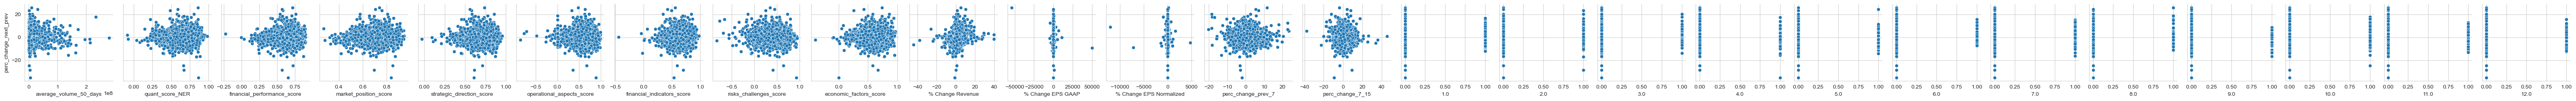

In [9]:
# PairPlot
sns.pairplot(data=df, x_vars=features, y_vars=['perc_change_next_prev'], kind='scatter')

In [10]:
# Create feature matrix, X and target, y
X, y = df[features].copy(), df['perc_change_next_prev'].copy()

# XGBoost Regressor

### Time-based Data Split

In this section, we divide the data sequentially. Interestingly, the evaluation metrics closely resemble those obtained from averaging over a thousand random splits of the data.

In [11]:
# Time Based Split
# Baseline MSE, Linear Regression, XGBoost
train_idx = int(0.8*len(df))
df_train, df_test = df.iloc[:train_idx].copy(), df.iloc[train_idx:].copy()
X_train, y_train = df_train[features], df_train['perc_change_next_prev']
X_test, y_test = df_test[features], df_test['perc_change_next_prev']

## Use StandardScaler() to scale feature matrix
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
# Fit the baseline model
preds_0 = np.zeros(len(y_test))
baseline_mse = mean_squared_error(y_test, preds_0)
baseline_r2 = r2_score(y_test, preds_0)

# Fit the Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_mse = mean_squared_error(y_test, lin_reg.predict(X_test))
lin_reg_corr = np.corrcoef(y_test, lin_reg.predict(X_test))[0,1]
lin_reg_r2 = r2_score(y_test, lin_reg.predict(X_test))

# Fit the XGBoost model
# Instantiate an XGBoost regressor object
xg_reg = xgb.XGBRegressor(alpha = 0.1, learning_rate = 0.15, reg_lambda = 0.1, max_depth = 1, n_estimators = 60)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict and R2 score
preds = xg_reg.predict(X_test)
xgb_mse = mean_squared_error(y_test, preds)
xgb_corr = np.corrcoef(y_test, preds)[0,1]
xgb_r2 = r2_score(y_test, preds)

In [12]:
print('Time-based Data Split yields:')
print()
print(f'Baseline MSE: {baseline_mse}, LinReg MSE: {lin_reg_mse}, XGBoost MSE: {xgb_mse}')
print()
print(f'Baseline R2: {baseline_r2}, LinReg R2: {lin_reg_r2}, XGBoost R2: {xgb_r2}')
print()
print(f'Baseline Corr: NA, LinReg Corr: {lin_reg_corr}, XGBoost Corr: {xgb_corr}')

Time-based Data Split yields:

Baseline MSE: 32.286483408071746, LinReg MSE: 31.376955652987107, XGBoost MSE: 30.698551063142027

Baseline R2: -0.0070984154470787875, LinReg R2: 0.021272093331275332, XGBoost R2: 0.04243327644402639

Baseline Corr: NA, LinReg Corr: 0.1732161007495599, XGBoost Corr: 0.20699982214256954


### Random Data Split

First, we use cross-validation to fine-tune the hyperparameters. Then, we execute the models 1,000 times using random train-test splits.

In [13]:
# Use Cross Validation for hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2, stratify = df['Ticker'])

## Set up the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),          
    ('xgb', XGBRegressor())                
])

# Define the grid of parameters to search
param_grid = {
    'xgb__n_estimators' : [40, 50, 60],
    'xgb__alpha': [0.1, 1, 10],
    'xgb__lambda': [0.1, 1, 10],
    'xgb__eta': [0.05, 0.1, 0.15],
    'xgb__max_depth': [1, 2, 3],
}

# Set up the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

print(f'Best score: {grid_search.best_score_}')
print('Best parameters found: ', grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best score: 0.046737275964648495
Best parameters found:  {'xgb__alpha': 1, 'xgb__eta': 0.15, 'xgb__lambda': 1, 'xgb__max_depth': 1, 'xgb__n_estimators': 40}


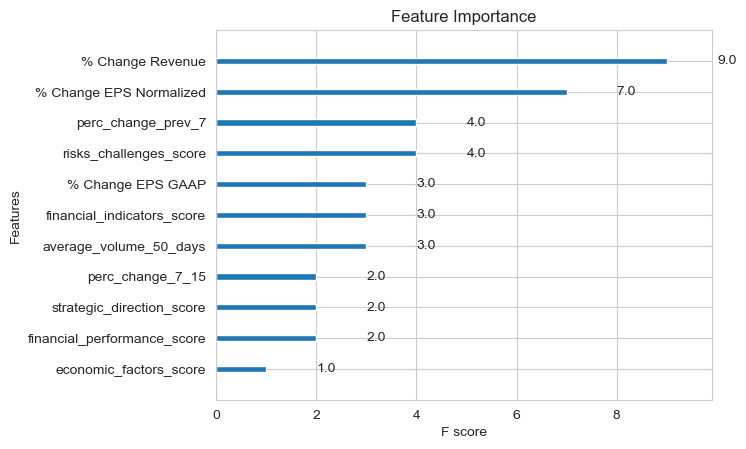

In [14]:
# Feature importance
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

xgb_model = best_model.named_steps['xgb']

xgb_model.get_booster().feature_names = [col for col in X_train.columns]

# Plot feature importance
plot_importance(xgb_model, importance_type='weight', title='Feature Importance', xlabel='F score', ylabel='Features')
plt.show()

In [15]:
# A function to evaluate profit multiplier
def profit_compare(y_pred, y_test, new_df):
    new_df.reset_index(drop=True, inplace=True)
    tickers = set(new_df['Ticker'].values)
    diffs = []

    for ticker in tickers:
        #print(ticker)
        mult_strat = 1
        mult_rand = 1
        mult_buy = 1
        X_ticker = new_df[new_df['Ticker']==ticker]
        indices = X_ticker.index

        for i in indices:
            if y_pred[i] >= 0:
                mult_strat=mult_strat*(1+(y_test[i]/100))
            else:
                mult_strat=mult_strat*(1-(y_test[i]/100))
            toss = np.random.binomial(1,0.5)
            if toss > 0:
                mult_rand=mult_rand*(1+(y_test[i]/100))
            else:
                mult_rand=mult_rand*(1-(y_test[i]/100))
            mult_buy=mult_buy*(1+(y_test[i]/100))
            
        
        #spx_final = spx_data['Close/Last'][spx_data['Date'].apply(datetime.date) == datetime.date(X_ticker['DateTime'].iloc[-1])].values[0]
        #spx_initial = spx_data['Close/Last'][spx_data['Date'].apply(datetime.date) == datetime.date(X_ticker['DateTime'].iloc[0])].values[0]

        #mult_spx = spx_final/spx_initial
        diffs.append([mult_strat, mult_rand, mult_buy])

        
        #print(mult_strat)
        #print(' ')

    return(np.mean(diffs, axis=0))        

In [16]:
# Run models 1000 times using random data split. Record mse, r2_scores, correlation, profit multiplier

num_iter = 1000

baseline_r2_scores = []     
linReg_r2_scores = []
xg_boost_r2_scores = []               

baseline_mse = []           
linReg_mse = []
xg_boost_mse = []
        
linReg_corr = []
xg_boost_corr = []

linReg_profit = []
xg_boost_profit = []

for _ in range(num_iter):
    df_train, df_test = train_test_split(df.copy(), shuffle=True, test_size=0.2, stratify=df['Ticker'])
    X_train, y_train = df_train[features].copy(), df_train['perc_change_next_prev'].copy()
    X_test, y_test = df_test[features].copy(), df_test['perc_change_next_prev'].copy()

    ## Use StandardScaler() to scale feature matrix
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit the baseline model
    preds_0 = np.zeros(len(y_test))
    baseline_mse.append(mean_squared_error(y_test, preds_0))
    
    # Fit the Linear Regression on scaled data
    linReg = LinearRegression()
    linReg.fit(X_train_scaled, y_train)
    linReg_preds = linReg.predict(X_test_scaled)
    linReg_mse.append(mean_squared_error(y_test, linReg_preds))
    linReg_r2_scores.append(r2_score(y_test, linReg_preds))
    linReg_corr.append(np.corrcoef(y_test, linReg_preds)[0, 1])

    # Fit the XGBoost model
    xg_boost = xgb.XGBRegressor(alpha=0.1, learning_rate=0.15, reg_lambda=0.1, max_depth=1, n_estimators=40)
    xg_boost.fit(X_train_scaled, y_train)
    xg_boost_preds = xg_boost.predict(X_test_scaled)
    xg_boost_mse.append(mean_squared_error(y_test, xg_boost_preds))
    xg_boost_r2_scores.append(r2_score(y_test, xg_boost_preds))
    xg_boost_corr.append(np.corrcoef(y_test, xg_boost_preds)[0, 1])
    
    new_df = X_test
    new_df['Ticker'] = df_test['Ticker']
    linReg_profit.append(profit_compare(linReg_preds, y_test, X_test))
    xg_boost_profit.append(profit_compare(xg_boost_preds, y_test, X_test))

In [21]:
# Results
print('Average evaluation metrics over 1000 runs: ')
print()
print(f'Baseline MSE: {np.mean(baseline_mse)}, LinReg MSE: {np.mean(linReg_mse)}, XGBoost MSE: {np.mean(xg_boost_mse)}')
print()
print(f'Baseline R2: {np.mean(baseline_r2_scores)}, LinReg R2: {np.mean(linReg_r2_scores)}, XGBoost R2: {np.mean(xg_boost_r2_scores)}')
print()
print(f'Baseline Corr: NA, LinReg Corr: {np.mean(linReg_corr)}, XGBoost Corr: {np.mean(xg_boost_corr)}')

Average evaluation metrics over 1000 runs: 

Baseline MSE: 25.21005950896861, LinReg MSE: 24.35210822863861, XGBoost MSE: 23.85591871956903

Baseline R2: nan, LinReg R2: 0.024772854272023404, XGBoost R2: 0.04516755240689042

Baseline Corr: NA, LinReg Corr: 0.1864122782619872, XGBoost Corr: 0.22113105513177522


In [18]:
# Average multiplicative factor
print(f'Multiplicative Strategy Score using Linear Regression: {np.mean(linReg_profit, axis = 0)[0]}')
print()
print(f'Multiplicative Strategy Score using XGBoost: {np.mean(xg_boost_profit, axis = 0)[0]}')

Multiplicative Strategy Score using Linear Regression: 1.0353812003883944

Multiplicative Strategy Score using XGBoost: 1.048957618751435


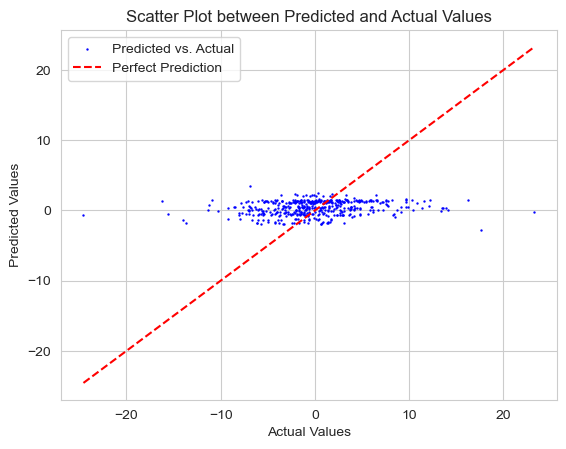

In [19]:
# Scatter plot of xg_boost_preds vs y_test

plt.scatter(y_test, xg_boost_preds, color='blue', s = 0.5, label='Predicted vs. Actual')

# Plot a line of perfect predictions for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Scatter Plot between Predicted and Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

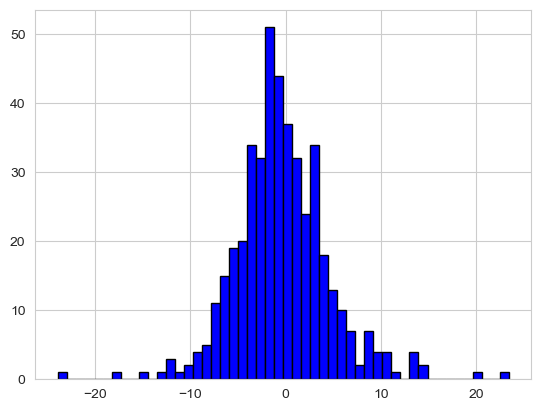

In [20]:
# Scatter plot of residuals
plt.hist(y_test - xg_boost_preds, bins = 50, color='blue', edgecolor='black')
plt.show()